# Package Imports

In [ ]:
!pip install yesg

  Preparing metadata (setup.py) ... done
  Created wheel for yesg: filename=yesg-2.1.1-py3-none-any.whl size=6105 sha256=1f32330614b67e38245562e7af0159e3aff41fe7f7a416516bb99484c5011966
  Stored in directory: /root/.cache/pip/wheels/2b/53/0e/129a8d67d809bf89a196f3ea3e56b9df3da4975924157cb1a3
Successfully built yesg


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import yfinance as yf
import yesg
import datetime
import warnings
warnings.filterwarnings("ignore")


# Load Dataset
- price data ... can be obtained without external file. obtained through yfinance.
- ESG data ... can be obtained without external file. obtained through yesg.
- S&P500 weights ... needs external file. below codes loads data from the saved csv file (data file path needs to be adjusted). this data is not necessary if you don't need to calculate the performance metrics for S&P500 as a benchmark, so it can be omitted.

## Data must satisfy following to be used in the model traning without additional adjustments:
- price data (price_df) is pandas dataframe with dimension (time, number of assets)
- columns of price data represents asset tickers
- ESG data is a torch tensor, and element order corresponds to the order of the asset tickers in the price data. has dimension of (number of assets)
- price data should be separated into traning dataframe (name: df) and dataframe for performance metrics computation (name: test).

In [ ]:
def get_sp500_tickers():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    tables = pd.read_html(url)
    df = tables[0]
    tickers = df['Symbol'].tolist()

    # Replace any dots in ticker symbols with hyphens (e.g., BRK.B to BRK-B)
    tickers = [ticker.replace('.', '-') for ticker in tickers]
    return tickers


def download_price_data(tickers, start_date, end_date):
 # Initialize an empty DataFrame to store adjusted close prices
    price_data = pd.DataFrame()

    # Due to limitations, download data in batches
    batch_size = 50  # Adjust batch size if necessary
    for i in range(0, len(tickers), batch_size):
        batch_tickers = tickers[i:i+batch_size]
        print(f"Downloading batch {i//batch_size + 1}: {batch_tickers}")
        data = yf.download(
            tickers=batch_tickers,
            start=start_date,
            end=end_date,
            interval='1d',
            auto_adjust=False,
            group_by='ticker',
            threads=True
        )

        # Handle the data depending on whether multiple tickers are returned
        if len(batch_tickers) == 1:
            ticker = batch_tickers[0]
            price_data[ticker] = data['Adj Close']
        else:
            for ticker in batch_tickers:
                if ticker in data.columns.levels[0]:
                    price_data[ticker] = data[ticker]['Adj Close']
                else:
                    print(f"Data for {ticker} not found.")

    # Drop any columns with all NaN values
    price_data.dropna(axis=1, how='all', inplace=True)

    # Sort the DataFrame by date
    price_data.sort_index(inplace=True)

    return price_data

In [ ]:
# Get the list of S&P 500 tickers
sp500_tickers = get_sp500_tickers()

# Add the S&P 500 index ticker
sp500_index_ticker = '^GSPC'
sp500_tickers.append(sp500_index_ticker)

# Define the date range for the past 5 years
end_date = datetime.datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.datetime.today() - datetime.timedelta(days=5*365)).strftime('%Y-%m-%d')

# Download the price data
price_df = download_price_data(sp500_tickers, start_date, end_date)


[*********************100%***********************]  50 of 50 completed
[                       0%                       ]

[*********************100%***********************]  50 of 50 completed
[                       0%                       ]

[*********************100%***********************]  50 of 50 completed
[                       0%                       ]

[*********************100%***********************]  50 of 50 completed
[                       0%                       ]

[*********************100%***********************]  50 of 50 completed


[*********************100%***********************]  50 of 50 completed
[                       0%                       ]

[*********************100%***********************]  50 of 50 completed
[                       0%                       ]

[*********************100%***********************]  50 of 50 completed
[**                     4%                       ]  2 of 50 completed

[*********************100%***********************]  50 of 50 completed
[                       0%                       ]

[*********************100%***********************]  50 of 50 completed
[                       0%                       ]

[*********************100%***********************]  4 of 4 completed


In [ ]:
price_df

,MMM,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,A,...,WMB,WTW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZTS,^GSPC
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-04 00:00:00+00:00,114.176102,42.363850,78.067741,70.368492,185.442352,302.510010,39.689999,16.132212,46.320751,78.189499,...,16.349045,180.329025,115.566658,53.335014,71.028564,90.822243,253.210007,138.628586,115.338234,3112.760010
2019-12-05 00:00:00+00:00,112.283875,42.848057,78.122711,69.981140,185.693207,303.029999,39.619999,16.055386,46.665966,78.769180,...,16.393373,180.926147,115.109215,53.446831,70.585693,90.199661,251.619995,137.927872,115.694633,3117.429932
2019-12-06 00:00:00+00:00,117.134003,42.747559,78.342705,70.190948,188.201920,306.230011,39.630001,15.978568,46.904957,79.426170,...,16.541119,182.297623,118.428093,53.326416,70.972023,90.428543,256.920013,138.778107,117.245445,3145.909912
2019-12-09 00:00:00+00:00,116.013710,41.459373,76.867134,69.755188,187.718765,307.049988,38.930000,16.038315,46.958061,78.856140,...,16.917898,181.737854,117.172569,53.094189,71.047417,90.620796,253.789993,137.086929,116.773460,3135.959961
2019-12-10 00:00:00+00:00,114.531326,41.468513,77.499504,69.852005,187.579407,304.170013,39.439999,16.328524,47.055435,80.121780,...,16.947453,181.551254,116.218758,53.154388,71.433746,90.858856,256.809998,135.694763,118.266487,3132.520020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-22 00:00:00+00:00,128.419998,73.440002,117.760002,176.949997,358.660004,512.150024,138.350006,13.040000,112.389999,133.839996,...,59.650002,314.399994,91.290001,71.349998,126.515785,135.270004,397.190002,110.220001,176.960007,5969.339844
2024-11-25 00:00:00+00:00,130.320007,75.430000,118.129997,177.059998,361.290009,518.729980,141.130005,13.160000,113.199997,134.490005,...,58.189999,314.630005,93.449997,71.599998,128.580002,137.050003,400.940002,110.959999,178.710007,5987.370117
2024-11-26 00:00:00+00:00,132.949997,73.900002,117.959999,181.139999,363.179993,525.299988,137.720001,12.580000,114.019997,134.369995,...,58.369999,316.649994,91.860001,71.870003,124.540001,138.630005,402.450012,110.639999,175.699997,6021.629883


In [ ]:
#price_df.to_csv('/content/drive/MyDrive/zemi_3rd_sem/week5,6/sp500_price_data_raw.csv')

In [ ]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1256 entries, 2019-12-04 00:00:00+00:00 to 2024-11-29 00:00:00+00:00
Columns: 504 entries, MMM to ^GSPC
dtypes: float64(504)
memory usage: 4.8 MB


In [ ]:
# Drop columns with at least one NaN value
price_df.dropna(axis=1, inplace=True)
price_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1256 entries, 2019-12-04 00:00:00+00:00 to 2024-11-29 00:00:00+00:00
Columns: 492 entries, MMM to ^GSPC
dtypes: float64(492)
memory usage: 4.7 MB


In [ ]:
ESG_scores = []
for col in price_df.columns:
    print(col)
    try:
      score = yesg.get_historic_esg(col)["Total-Score"][-1]
      ESG_scores.append(score)
    except TypeError:
      print(f"no ESG data available from {col}")
      if col != "^GSPC":
        price_df = price_df.drop(columns=[col])

ESG_scores = np.array(ESG_scores)
ESG_scores

MMM
AOS
ABT
ABBV
ACN
ADBE
AMD
AES
AFL
A
APD
AKAM
ALB
ARE
ALGN
ALLE
LNT
ALL
GOOGL
GOOG
An error has occurred. The ticker symbol might be wrong or you might need to wait to continue.
no ESG data available from GOOG
MO
AMZN
AMCR
AEE
AEP
AXP
AIG
AMT
AWK
AMP
AME
AMGN
APH
ADI
ANSS
AON
APA
AAPL
AMAT
APTV
ACGL
ADM
ANET
AJG
AIZ
T
ATO
ADSK
ADP
AZO
AVB
AVY
AXON
BKR
BALL
BAC
BAX
BDX
BRK-B
BBY
TECH
BIIB
BLK
BX
BK
BA
BKNG
BWA
BSX
BMY
AVGO
BR
BRO
BF-B
BLDR
BG
BXP
CHRW
CDNS
CZR
CPT
CPB
COF
CAH
KMX
CCL
CTLT
CAT
CBOE
CBRE
CDW
CE
COR
CNC
CNP
CF
CRL
SCHW
CHTR
CVX
CMG
CB
CHD
CI
CINF
CTAS
CSCO
C
CFG
CLX
CME
CMS
KO
CTSH
CL
CMCSA
CAG
COP
ED
STZ
COO
CPRT
GLW
CPAY
CTVA
CSGP
COST
CTRA
CRWD
CCI
CSX
CMI
CVS
DHR
DRI
DVA
DAY
DECK
DE
DELL
DAL
DVN
DXCM
FANG
DLR
DFS
DG
DLTR
D
DPZ
DOV
DOW
DHI
DTE
DUK
DD
EMN
ETN
EBAY
ECL
EIX
EW
EA
ELV
EMR
ENPH
ETR
EOG
EPAM
EQT
EFX
EQIX
EQR
ERIE
ESS
EL
EG
EVRG
ES
EXC
EXPE
EXPD
EXR
XOM
FFIV
FDS
FICO
FAST
FRT
FDX
FIS
FITB
FSLR
FE
FI
FMC
F
FTNT
FTV
FOXA
FOX
An error has occurred. The ticker 

array([40.71, 26.82, 22.21, 26.1 , 11.91, 14.06, 13.83, 23.48, 17.46,
       11.36, 14.83, 13.31, 20.11, 13.14, 18.58, 19.83, 17.11, 21.29,
       23.89, 31.32, 29.01, 14.69, 26.23, 22.09, 18.28, 23.6 , 12.62,
       19.07, 18.71, 21.13, 22.76, 17.89, 18.28, 14.5 , 15.29, 43.08,
       16.79, 11.56, 12.89, 20.27, 31.26, 13.71, 20.26, 23.48, 22.07,
       31.23, 15.14, 15.12, 10.98,  8.09, 15.39, 30.49, 19.12, 10.31,
       24.36, 21.84, 23.67, 26.19, 13.8 , 55.17, 20.51, 18.25, 23.59,
       19.93, 36.55, 16.35,  9.93, 22.06, 21.2 , 19.2 , 15.48, 21.11,
       25.76, 26.73, 32.92, 11.99, 17.36, 11.43, 20.24, 14.18, 26.3 ,
       21.31, 11.32, 11.08, 21.28, 20.8 , 28.33, 21.46,  6.31,  7.49,
       24.66, 10.97, 15.29, 24.78, 28.  , 18.14, 23.3 , 23.69, 35.31,
       20.12, 22.4 , 22.65, 12.99, 23.11, 17.03, 12.91, 22.12, 22.97,
       20.03, 17.08, 20.26, 24.16, 15.19, 24.12, 22.15, 26.81, 33.14,
       21.11, 26.39, 14.69, 15.68, 16.74, 22.46, 33.76, 21.24, 29.12,
       32.75, 17.75,

In [ ]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1256 entries, 2019-12-04 00:00:00+00:00 to 2024-11-29 00:00:00+00:00
Columns: 488 entries, MMM to ^GSPC
dtypes: float64(488)
memory usage: 4.7 MB


In [ ]:
#price_df.to_csv('/content/drive/MyDrive/zemi_3rd_sem/week5,6/sp500_price_data_dropped.csv')

In [ ]:
ESG_scores = torch.tensor(ESG_scores, dtype=torch.float32)
len(ESG_scores)

487

In [ ]:
#pickle.dump(ESG_scores, open('/content/drive/MyDrive/zemi_3rd_sem/week5,6/sp500_ESG_scores.pkl', 'wb'))

In [ ]:
test = price_df[-252:][[col for col in price_df.columns if col != "^GSPC"]]
df = price_df[:-252][[col for col in price_df.columns if col != "^GSPC"]]

In [ ]:
# https://www.slickcharts.com/sp500
spesg = pd.read_csv("/content/drive/MyDrive/zemi_3rd_sem/week5,6/S&P_weights_20241203 - Sheet1.csv")

# Load Dataset (if already saved with pickle)
- if just using the files in the drive, can just load it.
- data file path needs to be adjusted.

In [ ]:
price_df = pd.read_csv('/content/drive/MyDrive/zemi_3rd_sem/week5,6/sp500_price_data_dropped.csv', index_col=0)
ESG_scores = pickle.load(open('/content/drive/MyDrive/zemi_3rd_sem/week5,6/sp500_ESG_scores.pkl', 'rb'))
test = price_df[-252:][[col for col in price_df.columns if col != "^GSPC"]]
df = price_df[:-252][[col for col in price_df.columns if col != "^GSPC"]]

In [ ]:
# https://www.slickcharts.com/sp500
spesg = pd.read_csv("/content/drive/MyDrive/zemi_3rd_sem/week5,6/S&P_weights_20241203 - Sheet1.csv")

# Model Implementation
- Neural network architecture
- Loss functions
- Dataset & Dataloader


In [ ]:
# reference: https://arxiv.org/pdf/2005.13665

class LSTMPortfolioModel(nn.Module):
    def __init__(self, num_assets, hidden_size, num_layers=1):
        super(LSTMPortfolioModel, self).__init__()

        # Shared LSTM component to handle time series data
        self.shared_lstm = nn.LSTM(input_size=num_assets, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

        # Allocation component
        self.allocation_mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_assets)
        )

        # Prediction component
        self.prediction_mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_assets)
        )

    def forward(self, x):
        # Shared representation using LSTM
        lstm_out, _ = self.shared_lstm(x)  # lstm_out shape: (batch_size, time, hidden_size)

        # Take the last time step's output for further processing
        shared_output = lstm_out[:, -1, :]  # Shape: (batch_size, hidden_size)

        # Allocation weights with softmax normalization
        allocation_output = self.allocation_mlp(shared_output)
        allocation_weights = F.softmax(allocation_output, dim=1)

        # Predicted future prices
        predicted_prices = self.prediction_mlp(shared_output)

        return allocation_weights, predicted_prices

class TransformerPortfolioModel(nn.Module):
    def __init__(self, num_assets, hidden_size, num_layers=1, num_heads=4, dropout=0.1):
        super(TransformerPortfolioModel, self).__init__()

        # Input projection to match the Transformer d_model
        self.input_projection = nn.Linear(num_assets, hidden_size)

        self.positional_encoding = PositionalEncoding(hidden_size)

        # Shared attention-based component (Transformer Encoder)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads, dropout=dropout)
        self.shared_transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Allocation component
        self.allocation_mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_assets)
        )

        # Prediction component
        self.prediction_mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_assets)
        )

    def forward(self, x):
        # Project input to hidden size
        x = self.input_projection(x)  # Shape: (batch_size, time, hidden_size)

        x = self.positional_encoding(x)

        # Transformer expects input of shape (time, batch_size, hidden_size)
        x = x.permute(1, 0, 2)  # Shape: (time, batch_size, hidden_size)

        # Shared representation using Transformer Encoder
        transformer_out = self.shared_transformer(x)  # Shape: (time, batch_size, hidden_size)

        # Take the last time step's output for further processing
        shared_output = transformer_out[-1, :, :]  # Shape: (batch_size, hidden_size)

        # Allocation weights with softmax normalization
        allocation_output = self.allocation_mlp(shared_output)
        allocation_weights = F.softmax(allocation_output, dim=1)

        # Predicted future prices
        predicted_prices = self.prediction_mlp(shared_output)

        return allocation_weights, predicted_prices

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

In [ ]:
def negative_sharpe_ratio_and_risk_loss(allocation_weights, price_series):
    # Compute returns over time (time-1 steps)
    returns = (price_series[:, 1:, :] - price_series[:, :-1, :]) / price_series[:, :-1, :]  # Shape: (batch_size, time-1, num_assets)

    # Portfolio returns over time
    portfolio_returns = torch.sum(returns * allocation_weights.unsqueeze(1), dim=2)  # Shape: (batch_size, time-1)

    # Mean and standard deviation over time
    mean_return = torch.mean(portfolio_returns, dim=1)  # Shape: (batch_size,)
    std_return = torch.std(portfolio_returns, dim=1) + 1e-6  # Shape: (batch_size,)

    # Sharpe ratio
    sharpe_ratio = mean_return / std_return  # Shape: (batch_size,)

    # Negative mean Sharpe ratio over the batch
    return -torch.mean(sharpe_ratio), torch.mean(std_return)

def negative_entropy(allocation_weights):
    entropy = torch.sum(allocation_weights * torch.log(allocation_weights + 1e-8), dim=1)  # Shape: (batch_size,)
    mean_entropy = torch.mean(entropy)
    return mean_entropy

def negative_weighted_ESG(allocation_weights, ESG_scores):
    weighted_ESG = torch.sum(allocation_weights * ESG_scores.unsqueeze(0), dim=1)  # Shape: (batch_size,)
    mean_weighted_ESG = torch.mean(weighted_ESG)
    return mean_weighted_ESG # changed to positive because yfinance ESG ratings are smaller the better

def prediction_loss(predicted_prices, actual_future_prices):
    loss = F.mse_loss(predicted_prices, actual_future_prices)
    return loss

def total_loss(allocation_weights, price_series, ESG_scores, predicted_prices, actual_future_prices,
               alpha=1.0, beta=1.0, gamma=1.0, delta=1.0, theta=1.0):
    sharpe_loss, risk_loss = negative_sharpe_ratio_and_risk_loss(allocation_weights, price_series)
    entropy_loss = negative_entropy(allocation_weights)
    ESG_loss = negative_weighted_ESG(allocation_weights, ESG_scores)
    pred_loss = prediction_loss(predicted_prices, actual_future_prices)

    total = (alpha * sharpe_loss +
             beta * entropy_loss +
             gamma * ESG_loss +
             delta * pred_loss +
             theta * risk_loss)
    return total, alpha * sharpe_loss, beta * entropy_loss, gamma * ESG_loss, delta * pred_loss, theta * risk_loss



In [ ]:
class PriceDataset(Dataset):
    def __init__(self, df, window_size, test_window):
        self.data = df.values  # Convert DataFrame to NumPy array
        self.window_size = window_size
        self.test_window = test_window
        self.num_assets = df.shape[1]
        # Adjust the length to ensure we don't go beyond the data length
        self.length = len(df) - window_size - test_window  # Number of samples

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # Extract the window of price data
        price_series = self.data[idx : idx + self.window_size]  # Shape: (window_size, num_assets)

        # Extract the one-step ahead future price (immediately after 'price_series')
        future_prices = self.data[idx + self.window_size]       # Shape: (num_assets,)

        # Extract the 'test_price_series' starting after 'future_prices'
        test_start_idx = idx + self.window_size + 1
        test_end_idx = test_start_idx + self.test_window
        test_price_series = self.data[test_start_idx : test_end_idx]  # Shape: (test_window, num_assets)

        # Convert to tensors
        price_series = torch.tensor(price_series, dtype=torch.float32)
        future_prices = torch.tensor(future_prices, dtype=torch.float32)
        test_price_series = torch.tensor(test_price_series, dtype=torch.float32)

        sample = {
            'price_series': price_series,
            'future_prices': future_prices,
            'test_price_series': test_price_series
        }
        return sample


# Model Training

In [ ]:
# recommended to use GPU runtime
torch.cuda.is_available()

True

In [ ]:
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

# Define window size and batch size
window_size = 252   # The number of time steps in each sample
test_window = 252
batch_size = 32   # Number of samples per batch
dataset = PriceDataset(df, window_size=window_size, test_window=test_window)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print(len(dataloader))

# Hyperparameters
num_assets = df.shape[1]         # Number of assets
hidden_size = 128       # Size of hidden layers
num_layers = 2    # Number of Shared layers
learning_rate = 0.0001   # Learning rate
num_epochs = 50     # Number of training epochs

sharpe_energy=1.0
entropy_energy=0.1
ESG_energy=0.01
prediction_energy=0.00000001
risk_energy=1

# Initialize model and optimizer
model = TransformerPortfolioModel(num_assets=num_assets, hidden_size=hidden_size, num_layers=num_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
ESG_scores = ESG_scores.to(device)

for epoch in range(num_epochs):
    epoch_total_loss = 0.0
    epoch_sharpe_loss = 0.0
    epoch_entropy_loss = 0.0
    epoch_ESG_loss = 0.0
    epoch_pred_loss = 0.0
    epoch_risk_loss = 0.0
    num_batches = 0

    for batch in dataloader:
        x = batch['price_series'].to(device)         # Shape: (batch_size, window_size, num_assets)
        actual_future_prices = batch['future_prices'].to(device)  # Shape: (batch_size, num_assets)
        y = batch['test_price_series'].to(device)  # Shape: (batch_size, test_window, num_assets)

        # Forward pass
        allocation_weights, predicted_prices = model(x)

        # Compute loss
        total, sharpe_loss, entropy_loss, ESG_loss, pred_loss, risk_loss = total_loss(
            allocation_weights,
            y,  # Using the input price series
            ESG_scores,
            predicted_prices,
            actual_future_prices,
            alpha=sharpe_energy,
            beta=entropy_energy,
            gamma=ESG_energy,
            delta=prediction_energy,
            theta=risk_energy
        )

        # Backpropagation and optimization
        optimizer.zero_grad()
        total.backward()
        optimizer.step()

        # Accumulate losses
        epoch_total_loss += total.item()
        epoch_sharpe_loss += sharpe_loss.item()
        epoch_entropy_loss += entropy_loss.item()
        epoch_ESG_loss += ESG_loss.item()
        epoch_pred_loss += pred_loss.item()
        epoch_risk_loss += risk_loss.item()
        num_batches += 1

    # Compute average losses for the epoch
    avg_total_loss = epoch_total_loss / num_batches
    avg_sharpe_loss = epoch_sharpe_loss / num_batches
    avg_entropy_loss = epoch_entropy_loss / num_batches
    avg_ESG_loss = epoch_ESG_loss / num_batches
    avg_pred_loss = epoch_pred_loss / num_batches
    avg_risk_loss = epoch_risk_loss / num_batches

    # Logging
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Total Loss: {avg_total_loss:.4f}, "
          f"Sharpe Loss: {avg_sharpe_loss:.4f}, "
          f"Entropy Loss: {avg_entropy_loss:.4f}, "
          f"ESG Loss: {avg_ESG_loss:.4f}, "
          f"Prediction Loss: {avg_pred_loss:.4f}",
          f"Risk Loss: {avg_risk_loss:.4f}")

16
Epoch [1/50], Total Loss: -0.4309, Sharpe Loss: -0.0300, Entropy Loss: -0.6178, ESG Loss: 0.2040, Prediction Loss: 0.0010 Risk Loss: 0.0119
Epoch [2/50], Total Loss: -0.4346, Sharpe Loss: -0.0320, Entropy Loss: -0.6158, ESG Loss: 0.2003, Prediction Loss: 0.0010 Risk Loss: 0.0119
Epoch [3/50], Total Loss: -0.4403, Sharpe Loss: -0.0357, Entropy Loss: -0.6124, ESG Loss: 0.1950, Prediction Loss: 0.0010 Risk Loss: 0.0118
Epoch [4/50], Total Loss: -0.4467, Sharpe Loss: -0.0408, Entropy Loss: -0.6067, ESG Loss: 0.1880, Prediction Loss: 0.0010 Risk Loss: 0.0117
Epoch [5/50], Total Loss: -0.4526, Sharpe Loss: -0.0471, Entropy Loss: -0.6000, ESG Loss: 0.1817, Prediction Loss: 0.0010 Risk Loss: 0.0117
Epoch [6/50], Total Loss: -0.4579, Sharpe Loss: -0.0542, Entropy Loss: -0.5940, ESG Loss: 0.1777, Prediction Loss: 0.0010 Risk Loss: 0.0117
Epoch [7/50], Total Loss: -0.4626, Sharpe Loss: -0.0637, Entropy Loss: -0.5877, ESG Loss: 0.1760, Prediction Loss: 0.0010 Risk Loss: 0.0117
Epoch [8/50], Tot

# Result Analysis & Performance Evaluation

In [ ]:
# @title Visualization Functions
def get_allocation_weights(df, model, device='cpu'):

    model.eval()  # Set the model to evaluation mode

    # Convert DataFrame to tensor
    price_series = torch.tensor(df.values, dtype=torch.float32).unsqueeze(0).to(device)  # Shape: (1, time, assets)

    # Forward pass through the model
    with torch.no_grad():
        allocation_weights, _ = model(price_series)
        allocation_weights = allocation_weights.squeeze(0).cpu()  # Shape: (assets,)

    return allocation_weights

def visualize_weighted_price_series(df, allocation_weights, benchmark_series_list=None, benchmark_labels=None, plot_horizon=252):
    # Ensure allocation_weights is a NumPy array
    if isinstance(allocation_weights, torch.Tensor):
        allocation_weights = allocation_weights.detach().cpu().numpy()

    # Compute the weighted price series
    weighted_prices = df.values.dot(allocation_weights)  # Shape: (time,)

    # Normalize the weighted price series
    weighted_prices = weighted_prices[-plot_horizon:]
    weighted_prices_normalized = weighted_prices / weighted_prices[0]

    # Prepare the plot
    plt.figure(figsize=(12, 6))

    # Plot the weighted price series
    plt.plot(df.index[-plot_horizon:], weighted_prices_normalized, label='Weighted Portfolio')

    # Plot benchmark series if provided
    if benchmark_series_list is not None:
        if not isinstance(benchmark_series_list, list):
            raise TypeError("benchmark_series_list must be a list of series or arrays.")
        if benchmark_labels is not None and len(benchmark_series_list) != len(benchmark_labels):
            raise ValueError("Length of benchmark_labels must match length of benchmark_series_list.")
        for idx, benchmark in enumerate(benchmark_series_list):
            # Ensure benchmark series is a NumPy array
            if isinstance(benchmark, pd.Series):
                benchmark_values = benchmark.values[-plot_horizon:]
                benchmark_index = benchmark.index[-plot_horizon:]
            elif isinstance(benchmark, np.ndarray):
                benchmark_values = benchmark[-plot_horizon:]
                benchmark_index = df.index[-plot_horizon:]  # Assume same index as df
            else:
                raise TypeError("Each benchmark series must be a pandas Series or NumPy array.")

            # Normalize the benchmark series
            benchmark_normalized = benchmark_values / benchmark_values[0]

            # Get label for the benchmark
            if benchmark_labels is not None:
                label = benchmark_labels[idx]
            else:
                label = f'Benchmark {idx+1}'

            # Plot the benchmark series
            plt.plot(benchmark_index, benchmark_normalized, label=label)

    # Finalize the plot
    plt.xlabel('Time')
    plt.ylabel('Normalized Price')
    plt.title('Portfolio vs. Benchmark(s)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return weighted_prices_normalized

def compute_sp500_weighted_esg(tickers, ESG_scores, spesg):
    # Ensure 'Symbol' column in 'spesg' matches the format of tickers
    spesg['Symbol'] = spesg['Symbol'].str.replace('.', '-', regex=False)

    # Create a DataFrame for tickers and ESG scores
    df_tickers = pd.DataFrame({
        'Ticker': tickers,
        'ESG_Score': ESG_scores
    })

    # Merge df_tickers with spesg on ticker symbols
    merged_df = pd.merge(df_tickers, spesg, left_on='Ticker', right_on='Symbol', how='inner')

    # Compute weighted ESG score
    merged_df['Weighted_ESG'] = merged_df['ESG_Score'] * merged_df['Weight']

    # Sum of weights used (since some tickers may have been skipped)
    sum_of_weights_used = merged_df['Weight'].sum()

    # Total weighted ESG score
    total_weighted_esg = merged_df['Weighted_ESG'].sum()

    # Rescale to ensure the weights sum to 1
    weighted_esg = total_weighted_esg / sum_of_weights_used if sum_of_weights_used != 0 else np.nan

    return weighted_esg

def compute_weighted_esg_score(allocation_weights, ESG_scores):
    # Ensure weights and ESG scores are NumPy arrays
    allocation_weights = np.array(allocation_weights)
    ESG_scores = np.array(ESG_scores)

    # Handle any NaN or missing values in weights and ESG_scores
    valid_indices = ~np.isnan(allocation_weights) & ~np.isnan(ESG_scores)
    weights_valid = allocation_weights[valid_indices]
    ESG_scores_valid = ESG_scores[valid_indices]

    # Rescale weights to sum to 1
    weights_sum = weights_valid.sum()
    if weights_sum != 0:
        weights_normalized = weights_valid / weights_sum
        weighted_esg = np.dot(weights_normalized, ESG_scores_valid)
    else:
        weighted_esg = np.nan

    return weighted_esg

import numpy as np
import pandas as pd

def compute_performance_metrics(
    weighted_prices,
    allocation_weights,
    ESG_scores,
    tickers,
    spesg,
    benchmark_series_list=None,
    benchmark_labels=None,
    risk_free_rate=0.0,
    periods_per_year=252,
    n=None
):

    # Ensure weighted_prices is a pandas Series
    if not isinstance(weighted_prices, pd.Series):
        weighted_prices = pd.Series(weighted_prices)

    # Use only the last n data points if n is specified
    if n is not None:
        weighted_prices = weighted_prices.iloc[-n:]

    # Ensure allocation_weights and ESG_scores are NumPy arrays
    if isinstance(allocation_weights, torch.Tensor):
        allocation_weights = allocation_weights.detach().cpu().numpy()
    if isinstance(ESG_scores, torch.Tensor):
        ESG_scores = ESG_scores.detach().cpu().numpy()

    # Initialize lists to store metrics
    metrics = []
    labels = ['Weighted Portfolio']
    series_list = [weighted_prices]
    weights_list = [allocation_weights]

    # Include benchmark series if provided
    if benchmark_series_list is not None:
        if not isinstance(benchmark_series_list, list):
            raise TypeError("benchmark_series_list must be a list of series.")
        if benchmark_labels is not None:
            labels.extend(benchmark_labels)
        else:
            labels.extend([f'Benchmark {i+1}' for i in range(len(benchmark_series_list))])

        # For benchmarks, we'll assume equal weights and S&P 500 weights
        for idx, benchmark in enumerate(benchmark_series_list):
            if not isinstance(benchmark, pd.Series):
                benchmark = pd.Series(benchmark)
            # Use only the last n data points if n is specified
            if n is not None:
                benchmark = benchmark.iloc[-n:]
            series_list.append(benchmark)

            # Determine weights for the benchmark
            if benchmark_labels[idx] == 'Equal Weight':
                # Equal weights
                equal_weights = np.ones(len(ESG_scores)) / len(ESG_scores)
                weights_list.append(equal_weights)
            elif benchmark_labels[idx] == 'S&P500':
                # S&P 500 weights aligned with tickers
                sp500_weight_dict = dict(zip(spesg['Symbol'], spesg['Weight']))
                sp500_weights = np.array([sp500_weight_dict.get(ticker, 0.0) for ticker in tickers])
                weights_list.append(sp500_weights)
            else:
                # If weights are not specified, use equal weights
                equal_weights = np.ones(len(ESG_scores)) / len(ESG_scores)
                weights_list.append(equal_weights)

    # Compute metrics for each series
    for idx, series in enumerate(series_list):
        # Calculate daily returns
        returns = series.pct_change().dropna()

        # Total return
        total_return = (series.iloc[-1] / series.iloc[0]) - 1

        # Adjust periods per year based on the length of the data used
        periods = len(series)
        annual_factor = periods_per_year / periods if periods != 0 else np.nan

        # Annualized return
        annualized_return = (1 + total_return) ** annual_factor - 1 if periods != 0 else np.nan

        # Annualized volatility
        annualized_volatility = returns.std() * np.sqrt(periods_per_year)

        # Sharpe ratio
        excess_returns = returns - risk_free_rate / periods_per_year
        sharpe_ratio = (excess_returns.mean() / returns.std()) * np.sqrt(periods_per_year) if returns.std() != 0 else np.nan

        # Maximum drawdown
        cumulative_returns = (1 + returns).cumprod()
        peak = cumulative_returns.cummax()
        drawdown = (cumulative_returns - peak) / peak
        max_drawdown = drawdown.min()

        # Sortino ratio
        downside_returns = returns.copy()
        downside_returns[downside_returns > 0] = 0
        downside_deviation = downside_returns.std() * np.sqrt(periods_per_year)
        sortino_ratio = (returns.mean() * periods_per_year - risk_free_rate) / downside_deviation if downside_deviation != 0 else np.nan

        # Calmar ratio
        calmar_ratio = (returns.mean() * periods_per_year - risk_free_rate) / abs(max_drawdown) if max_drawdown != 0 else np.nan

        # Weighted ESG score
        weights = weights_list[idx]
        weighted_esg_score = compute_weighted_esg_score(weights, ESG_scores)

        # Append metrics to the list
        metrics.append({
            'Total Return': total_return,
            'Annualized Return': annualized_return,
            'Annualized Volatility': annualized_volatility,
            'Sharpe Ratio': sharpe_ratio,
            'Sortino Ratio': sortino_ratio,
            'Calmar Ratio': calmar_ratio,
            'Max Drawdown': max_drawdown,
            'Weighted ESG Score': weighted_esg_score
        })

    # Create a DataFrame from the metrics
    metrics_df = pd.DataFrame(metrics, index=labels)

    # Format the DataFrame for better readability
    metrics_df_formatted = metrics_df.applymap(lambda x: f"{x:.4f}" if pd.notnull(x) else "NaN")

    # Display the metrics table
    print("\nPerformance Metrics:")
    display(metrics_df_formatted)

    return metrics_df



In [ ]:
allocation_weights = get_allocation_weights(df[-window_size:], model, device).flatten() # or input full df
allocation_weights.shape

torch.Size([487])

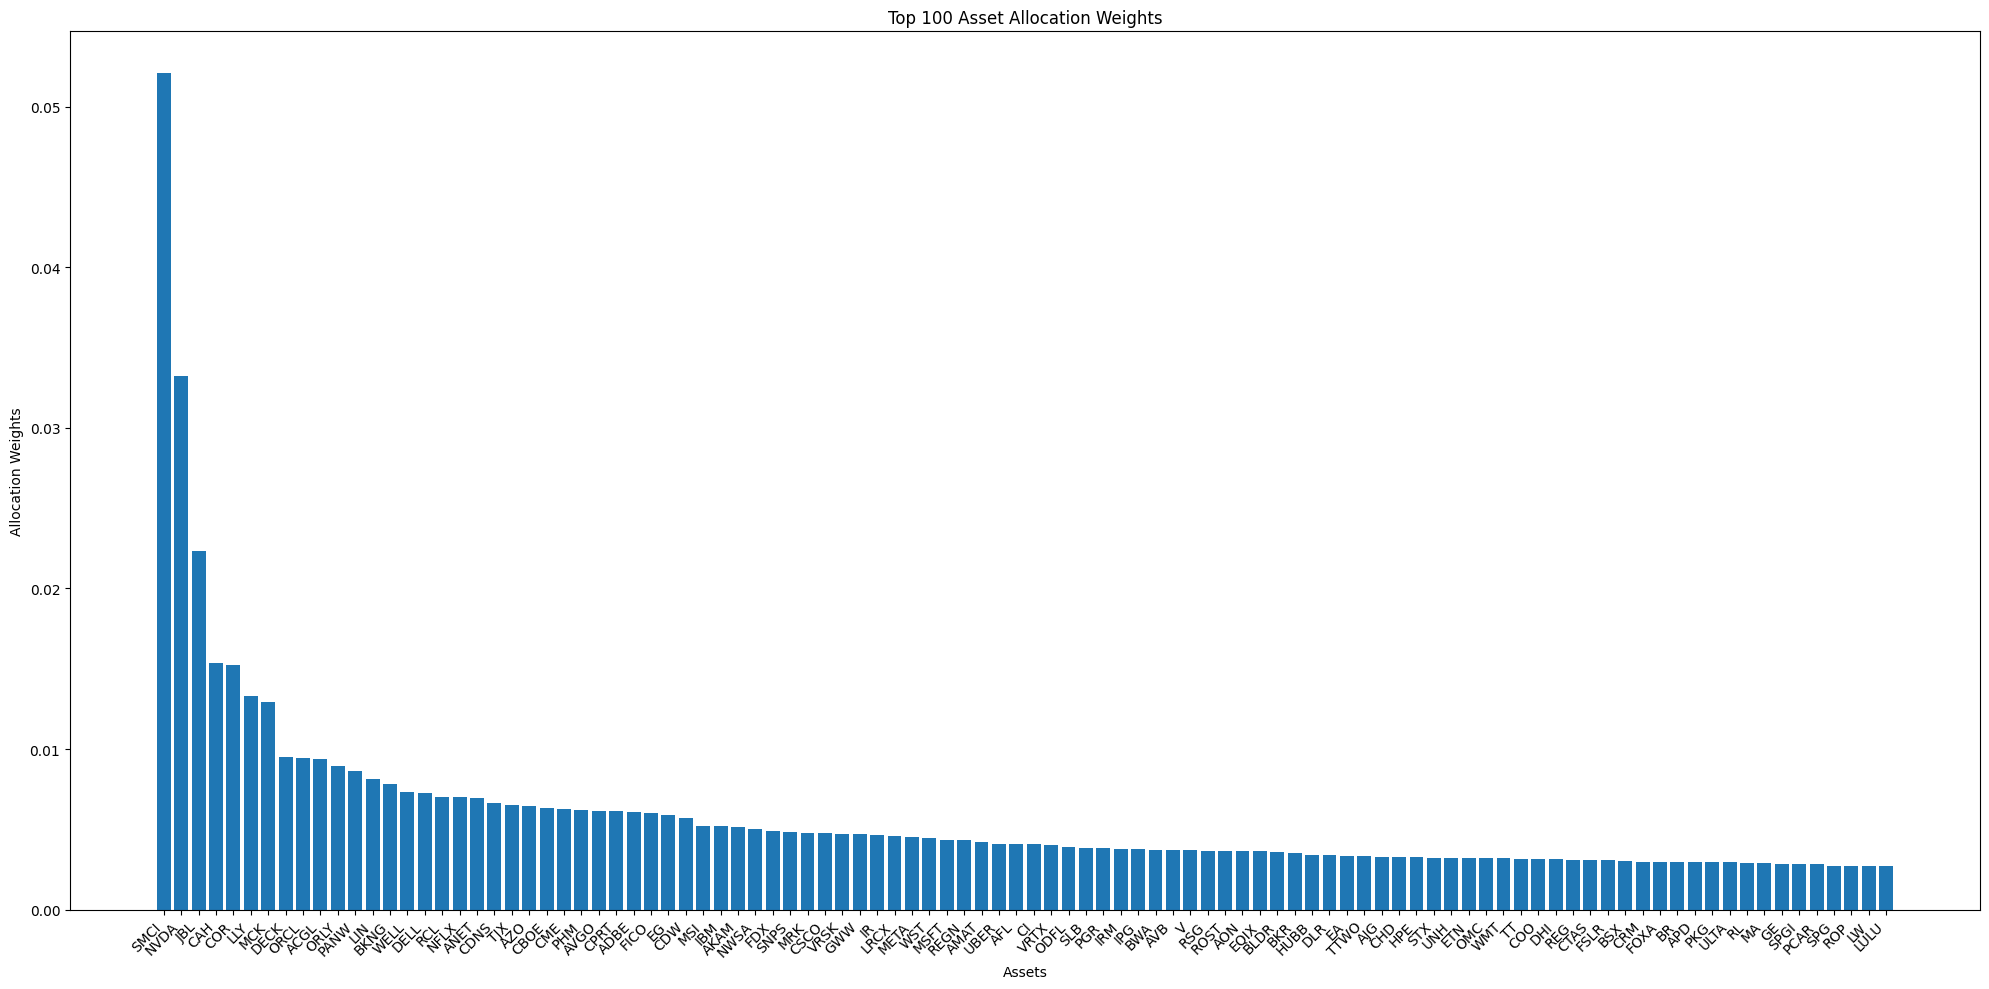

In [ ]:
def plot_top_n_assets(df, allocation_weights, n=100):
    if isinstance(allocation_weights, torch.Tensor):
        allocation_weights = allocation_weights.detach().cpu().numpy()

    weights_df = pd.DataFrame({'Asset': df.columns.tolist(), 'Weight': allocation_weights})
    weights_df = weights_df.sort_values(by='Weight', ascending=False).head(n)

    plt.figure(figsize=(20, 10))
    plt.bar(weights_df['Asset'], weights_df['Weight'])
    plt.xlabel('Assets')
    plt.ylabel('Allocation Weights')
    plt.title(f'Top {n} Asset Allocation Weights')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_top_n_assets(df, allocation_weights)

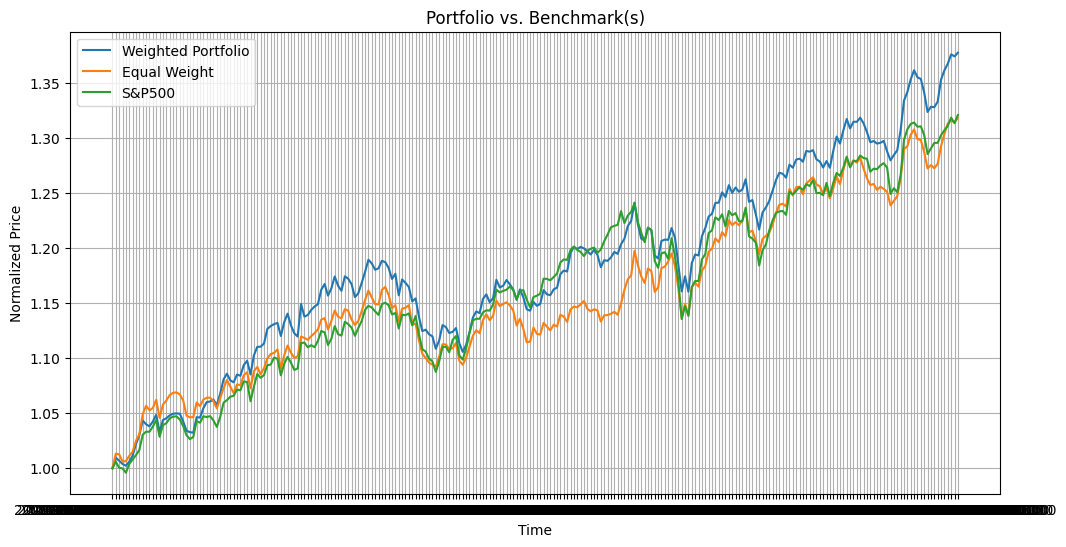

In [ ]:
weighted_prices = visualize_weighted_price_series(pd.concat([df, test]),
                                                  allocation_weights,
                                                   [pd.concat([df, test]).values.dot(torch.ones(df.shape[1])/df.shape[1]), price_df["^GSPC"]],
                                                    ["Equal Weight", "S&P500"],
                                                  plot_horizon=252)

In [ ]:
metrics_df = compute_performance_metrics(
    weighted_prices=weighted_prices,
    allocation_weights=allocation_weights,
    ESG_scores=ESG_scores,
    tickers=df.columns.tolist(),
    spesg=spesg,
    benchmark_series_list=[pd.concat([df, test]).values.dot(torch.ones(df.shape[1])/df.shape[1]), price_df["^GSPC"]],
    benchmark_labels=["Equal Weight", "S&P500"],
    risk_free_rate=0.03,  # Adjust as needed
    n=252
)


Performance Metrics:


,Total Return,Annualized Return,Annualized Volatility,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Max Drawdown,Weighted ESG Score
Weighted Portfolio,0.3772,0.3772,0.1213,2.4641,4.5151,4.2501,-0.0703,17.2404
Equal Weight,0.3180,0.3180,0.1182,2.1507,3.8789,4.0986,-0.0620,20.5984
S&P500,0.3206,0.3206,0.1228,2.0923,3.5052,3.0275,-0.0849,20.5416


In [ ]:
# saving model
